# Tree Model

## First section
In this section, import the necessary libraries

In [1]:
# array and data
import numpy as np
import pandas as pd

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, make_scorer, classification_report
from sklearn.tree import plot_tree


## Second section: Dataset

These data come from the booking systems of two real hotels and reflect bookings made between July 1st, 2015 through August 31st 2017.

If customers booked the orders, the hotel need to reserve the rooms and guarantee that these room is not occupied in the booked day for them and before arriving, the customers are allowed to cancel the orders. The hotels will suffer from the potential loss when an order canceled. Study on the reason why customers cancel their reservation should be drived from the hotel itself and the different information of the customers.

- The hotel suffer losses if there are some reservation canceled.
- The customers choose to cancel the books which is motivated by certain reasons reflected in the data.


In [2]:
df = pd.read_csv(r'D:\Edinburgh-Learn\MLIP\mlp-proj2-mlp-proj2\Code\Data\hotel.csv')  # These variables are showed that have no relationship with the outcome of interest
df.head()

,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,0,Resort Hotel,342,2015,July,27,1,0,0,2,...,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0
1,0,Resort Hotel,737,2015,July,27,1,0,0,2,...,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0
2,0,Resort Hotel,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0
3,0,Resort Hotel,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0
4,0,Resort Hotel,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1


In [4]:
p = df['is_canceled'].sum()/df.shape[0]
Ent = -p*np.log2(p)-(1-p)*np.log2(1-p)
print('the original information entropy is %0.2f'%Ent)

the original information entropy is 0.95


### Data Pre
There are too many features in our data, and we need to do some feature extraction and engineering to make it easy to model.

- Drop the `company`: `Company` has too much missing values, over 90%, and so, we drop this feature directly.
- Drop the `arrival_date_year`: There are three years data, but if we plot it with the probability of the canceled reservations, we will find it has no relationship with the outcome of interest
- Drop the `arrival_date_month`: This feature is dominated by the `arrival_date_week_number`, and the skitlearn prefer the numeric features.
- Transform the `reserved_room_type` and `assigned_room_type`: Assign a new feature and it is 1 if the reserved and assigned are same ortherwise it is 0
- Keep all the numeric features: Tree-based method require use use the float features.

Because this data is from real and have missing value and unneccesary features, we need to tidy our data and do some pre-study. First, we tackle those missing values by deleting the feature or imputing by certain values.

In [5]:
# ----Find the missing values----
missing = df.isna().apply(np.sum, axis=0)
# {children:4/0.000034, country:488/0.004087, agent:16340/0.136862, company:112593/0.943069}
missing[missing != 0]/119390

company    0.943069
dtype: float64

As we can see, the `company` loss 94% recoed (or don't have), and so, we just drop this feature because it can't provide enough information for our study. Then, we impute the `children` and `country` by their mode value and impute `agent` by 0 (means no agent).

In [6]:
# [1]. Children: only 4 missing value (nearly no effect on result after impute them by using mode)
children = df.loc[:, 'children']
children = children.fillna(0)


# [2]. agent: we regard the missing value as one of the attributes and take it into account.
#             Here, we just replace them of 'none':str
agent = df.loc[:, 'agent'].replace(np.nan, 0)

# [3]. country: Same as the children, we choose the mode to impute the data
country = df.loc[:, 'country']
country = country.fillna('PRT')

# [4]. company: Because there are too many missing values, we choose to drop this variable out.
# Fianlly, we get the final data
imputed = pd.concat([children, agent, country], axis=1)
df.loc[:, ['children', 'agent', 'country']] = imputed.values

Do some association analysis to explore the relative features. Tho goal fo this step is to reduce the dimensions of our data for implement of later tree based method

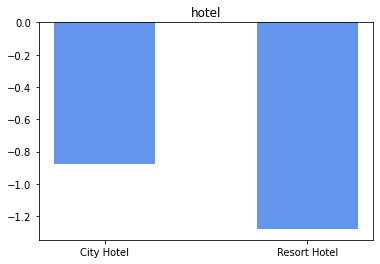

In [7]:
def univ_analysis_one(target: str, plot, data, axes, log=False):
    """This function is used to do some univ_analysis: If we grouped by the target variables,
    We can calculate the frenquency of the happens of canceled books. Return the prob matrix and
    visualize it
    

    Args:
        target (str): the target variable
        plot (bool): If plot=True, we plot the bars, or we will not plot
        data (DataFrame): The data we used

    Returns:
        prob_taget: The probability of the book will be canceled if in different status of the target
        variable.
    """
    _target = data.loc[:, ['is_canceled', target]]
    group_target = _target.groupby(by=target)
    cancel_target = group_target.sum()
    total_target = group_target.size()
    prob_target = [int(m)/int(n)
                   for m, n in zip(cancel_target.to_numpy(), total_target.to_numpy())]

    if log:
        log_prob_target = [np.log(p) for p in prob_target]
    else:
        log_prob_target = [p for p in prob_target]

    if plot:
        labels = list(group_target.groups.keys())
        ax = axes
        ax.bar(x=labels, width=0.5, height=log_prob_target,
               color=['cornflowerblue'])
        ax.set_title(target)
    return prob_target

fig = plt.figure()
ax1 = fig.add_subplot(111)
prob_hotel = univ_analysis_one('hotel',True, df, ax1, True)

From the plot, we see different hotel have different probability of canceled reservation and it seem significant. This difference is caused by the hotel itself, including its sanitary conditions, facilities and other factors. For this reason, we would like to keep this variable. However, this featuere is catigorical variable, and we need to use Onehot method to encode it in order to convert it to float type.

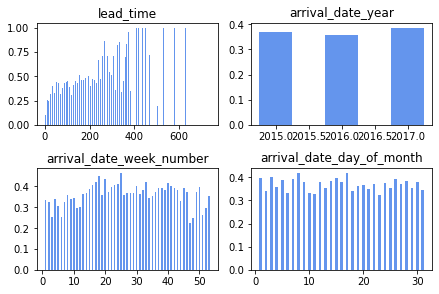

In [8]:
fig_time = plt.figure()
ax_lt = fig_time.add_subplot(221)
prob_lead_time = univ_analysis_one('lead_time', True, df, ax_lt)

ax2 = fig_time.add_subplot(222)
prob_arrival_year = univ_analysis_one('arrival_date_year', True, df, ax2)


ax3 = fig_time.add_subplot(223)
prob_arrival_weeks = univ_analysis_one(
    'arrival_date_week_number', True, df, ax3)  # non-linear relationship


ax4 = fig_time.add_subplot(224)
prob_arrival_days = univ_analysis_one(
    'arrival_date_day_of_month', True, df, ax4)  # not so obvious

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()
print()


As displayed in above plots, it is obvious that `lead_time` strongly related to the outcome of interest and `arrival_date_year` can be deleted directly because there is no significant difference between different years. As for `week_number` and `day_of_month`, we can't decide their relationship with the probability of canceled reservations. So, we remain them in our model temporarily.

In [9]:
adults = df.groupby(by='adults').count()['is_canceled']*100/df.shape[0]  # adults properties
children = df.groupby(by='children').count()['is_canceled']*100/df.shape[0]  # children properties
babies = df.groupby(by='babies').count()['is_canceled']*100/df.shape[0]  # babies properties
feature_proprtyies={
    "adults":adults,
    'children':children,
    'babies':babies
}
print('{0}\n{1}'.format(feature_proprtyies['children'],feature_proprtyies['babies']))

children
0.0     92.805093
1.0      4.071530
2.0      3.058883
3.0      0.063657
10.0     0.000838
Name: is_canceled, dtype: float64
babies
0     99.231929
1      0.753832
2      0.012564
9      0.000838
10     0.000838
Name: is_canceled, dtype: float64


As a result, we can just ignore the effect of the number of babies because over 99% customers booked without babies and for the same reason, we also can delete the `children`.

The information gain of meal is 0.005


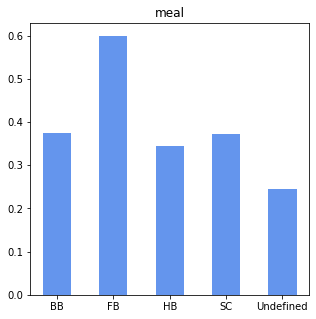

In [10]:
# meal
meal = df.groupby(by='meal').count()['is_canceled']/df.shape[0]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
prob_meal = univ_analysis_one('meal',True,df,ax)

# Define the function to calculate the information of entropy
def cal_Ent(prob:list):
    ent_list=[]    
    for p in prob:
        if p==1 or p==0:
            ent = 0
        else:
            ent = -p*np.log2(p)-(1-p)*np.log2(1-p)
            ent = round(ent,2)
        ent_list.append(ent)
    return ent_list

Ent_meal = cal_Ent(prob_meal)

# Define the function to calculate the information gain
def cal_Gain(Ent, Ent_new, prop):
    Gain = []
    n = len(Ent_new)
    for i in range(n):
        Gain.append(prop[i]*Ent_new[i])
    Gain = Ent-sum(Gain)
    return Gain

Gain_meal = cal_Gain(Ent,Ent_meal,list(meal))
print('The information gain of meal is %0.3f'%Gain_meal)


From the plot, we can find that the customers who choose FB are more likely to cancel their reservation. However, there are only 0.6% customers pick this meal. As for other meals, there are not obvious difference between each other. In other words, this feature also don't impact the rate of canceled reservations significantly. Besides If we calculate its information gain, we can find it just is 0.004, which is so small that we can ignore it. For thes reason, we also can delete this feature.

In [11]:
# country
country = df.groupby(by='country').count()['is_canceled']/df.shape[0]
print(country.sort_values(ascending=False).head())


country
PRT    0.411073
GBR    0.101591
FRA    0.087235
ESP    0.071765
DEU    0.061035
Name: is_canceled, dtype: float64


We choose to delete this characteristic because it divide our feature space too small and tight. If we really want to take this factor into our account because different countries may cause different results, we can adjust its coarse. For instance, we can just devide this feature into two group: PRT and not PRT.

The information gain of market segment is 0.669
The information gain of distribution channel is 0.022


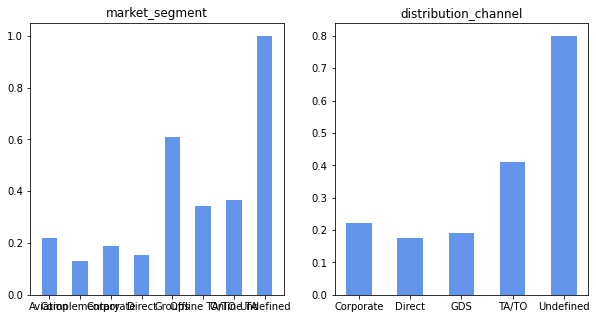

In [12]:
# market_segmrnt and distibution_channel
market_segment = df.groupby(by='market_segment').count()['is_canceled']/df.shape[0]
distribution_channel = df.groupby(by='distribution_channel').count()['is_canceled']/df.shape[0]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
prob_market = univ_analysis_one('market_segment', True, df, ax)

ax = fig.add_subplot(122)
prob_dist = univ_analysis_one('distribution_channel', True, df, ax)

Ent_market = cal_Ent(prob_market)
Gain_market = cal_Gain(Ent, Ent_meal, list(market_segment))

Ent_dist = cal_Ent(prob_dist)
Gain_dist = cal_Gain(Ent, Ent_dist, list(distribution_channel))
print('The information gain of market segment is %0.3f' % Gain_market)
print('The information gain of distribution channel is %0.3f' % Gain_dist)


As a result, this feature effect our interest significantly because its information gain is 0.669. So, we use onehot to encode this feature.

In [14]:
# Transform
# Convert the reserved room and the assigned room
res_room, ass_room = df.loc[:,
                            'reserved_room_type'], df.loc[:, 'assigned_room_type']
same_room = []
for i, j in zip(res_room, ass_room):
    if i == j:
        same_room.append(1)
    else:
        same_room.append(0)
df['same_room'] = same_room

ct = ColumnTransformer(
    [
        ('drop_feat', 'drop', ['company', 'arrival_date_year','arrival_date_month','agent','babies','children','meal','country','reserved_room_type','assigned_room_type',
        'deposit_type','customer_type','distribution_channel']),
        ('onthot',OneHotEncoder(),['hotel','market_segment'])
    ],
    remainder='passthrough'
)

ct.fit(df)
names = ct.get_feature_names()
dataset = pd.DataFrame(ct.transform(df), columns=names)
dataset.head()

,onthot__x0_City Hotel,onthot__x0_Resort Hotel,onthot__x1_Aviation,onthot__x1_Complementary,onthot__x1_Corporate,onthot__x1_Direct,onthot__x1_Groups,onthot__x1_Offline TA/TO,onthot__x1_Online TA,onthot__x1_Undefined,...,adults,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,same_room
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,75.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,75.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,98.0,0.0,1.0,1.0


## Second section: Model
In this section, we choose tree-base model to explore the reason why people choose to cancel their reservations.

### Data Split

The first step is to split our data into train and test part.

In [15]:
# Data split
X = dataset.drop(['is_canceled'],axis=1)
y = dataset['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)

In [18]:
dataset.dtypes

onthot__x0_City Hotel             float64
onthot__x0_Resort Hotel           float64
onthot__x1_Aviation               float64
onthot__x1_Complementary          float64
onthot__x1_Corporate              float64
onthot__x1_Direct                 float64
onthot__x1_Groups                 float64
onthot__x1_Offline TA/TO          float64
onthot__x1_Online TA              float64
onthot__x1_Undefined              float64
is_canceled                       float64
lead_time                         float64
arrival_date_week_number          float64
arrival_date_day_of_month         float64
stays_in_weekend_nights           float64
stays_in_week_nights              float64
adults                            float64
is_repeated_guest                 float64
previous_cancellations            float64
previous_bookings_not_canceled    float64
booking_changes                   float64
days_in_waiting_list              float64
adr                               float64
required_car_parking_spaces       

### Random Forest Model
In this section, we try to establish the random forest modle to achieve the goal of our study

In [14]:
# Find hyper search
def hyper_search(model, params, X, y, save_path, n_iter=60, metric="accuracy",
                 cv=KFold(5), random_state=42, refit=True,
                 overwrite=False, warning=False, verbose=0):
    if os.path.exists(save_path) and overwrite == False:
        #load the model
        models = joblib.load(save_path)
    else:
        # check all param inputs are lists
        if all(type(x) == list for x in params.values()):
            search_type = "Gridsearch"
            models = GridSearchCV(model, param_grid=params, scoring=metric, cv=cv,
                                  refit=refit, return_train_score=True, verbose=verbose)
            n_iter = len(list(itertools.product(*list(iter(params.values())))))
        else:
            search_type = "Randomsearch"
            if verbose > 0:
                print("Starting "+search_type)
            models = RandomizedSearchCV(model, param_distributions=params,
                                        n_iter=n_iter, scoring=metric, cv=cv,
                                        refit=refit, random_state=random_state,
                                        return_train_score=True, verbose=verbose)

        start = time()
        if warning:
            models.fit(X, y)
        else:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                models.fit(X, y)

        if verbose > 0:
            print(search_type + " took %.2f seconds for %d candidates" %
                  ((time() - start), n_iter))
        joblib.dump(models, save_path)

    return models


In [17]:
X_train.dtypes

onthot__x0_City Hotel             float64
onthot__x0_Resort Hotel           float64
onthot__x1_Aviation               float64
onthot__x1_Complementary          float64
onthot__x1_Corporate              float64
onthot__x1_Direct                 float64
onthot__x1_Groups                 float64
onthot__x1_Offline TA/TO          float64
onthot__x1_Online TA              float64
onthot__x1_Undefined              float64
lead_time                         float64
arrival_date_week_number          float64
arrival_date_day_of_month         float64
stays_in_weekend_nights           float64
stays_in_week_nights              float64
adults                            float64
is_repeated_guest                 float64
previous_cancellations            float64
previous_bookings_not_canceled    float64
booking_changes                   float64
days_in_waiting_list              float64
adr                               float64
required_car_parking_spaces       float64
total_of_special_requests         

In [16]:
# Ceate the Model
RF = RandomForestClassifier(criterion='gini', n_estimators = 100, random_state=123, oob_score=True,n_jobs=-1)
RF.fit(X_train, y_train)
RF.oob_score_

0.8636611106457828

In [16]:
report = pd.DataFrame(classification_report(y_test,
                                            RF.predict(X_test),
                                            labels=None,
                                            target_names=[0,1],
                                            sample_weight=None,
                                            digits=2,
                                            output_dict=True)).round(2)
report


,0,1,accuracy,macro avg,weighted avg
precision,0.87,0.86,0.87,0.86,0.87
recall,0.93,0.76,0.87,0.84,0.87
f1-score,0.90,0.81,0.87,0.85,0.86
support,15051.00,8827.00,0.87,23878.00,23878.00


0.8660273054694698


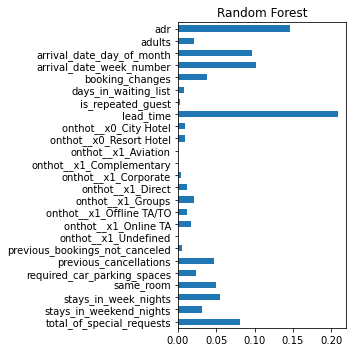

In [17]:
print(accuracy_score(y_test,RF.predict(X_test)))

# get the importances for the features
rf_importances = RF.feature_importances_

rf_importances_series = pd.Series(rf_importances,index=X.columns).sort_index(ascending = False)

# plot the important features
fig = plt.figure(figsize=(5,5))
axes = fig.add_subplot(111)
rf_importances_series.plot.barh(legend =False, grid=False, ax=axes)
axes.set_title('Random Forest')
plt.tight_layout()

In [18]:
# Simplify our model
rf_importances_series.sort_values(ascending=False).head()

lead_time                    0.208408
adr                          0.146668
arrival_date_week_number     0.101670
arrival_date_day_of_month    0.096616
total_of_special_requests    0.081055
dtype: float64

As displayed above, we just choose these 5 features to build our tree model.

In [19]:
# Define the final dataset
Final_data = dataset.loc[:,['lead_time','adr','arrival_date_week_number','arrival_date_day_of_month','total_of_special_requests']]


## Third section: Model tunning

In this question, we need to tune our model and we use `GridSearch()` to find the best parameters for our model.

In [20]:
# Find the best model
gs_rf = GridSearchCV(
    RandomForestClassifier(),
    {
        'max_depth':range(3,8),
        'max_features':range(4,10),
    },
    cv=KFold(5,shuffle=True,random_state=123)
).fit(X_train, y_train)

In [21]:
# Best estimater
gs_rf.best_estimator_

RandomForestClassifier(max_depth=7, max_features=4)

The best estimater is max_depth=7 and max_features=4.

In [25]:
y_pred = gs_rf.predict(X_test)
report = pd.DataFrame(classification_report(y_test,
                                            y_pred,
                                            labels=None,
                                            target_names=[0, 1],
                                            sample_weight=None,
                                            digits=2,
                                            output_dict=True)).round(2)
report


,0,1,accuracy,macro avg,weighted avg
precision,0.80,0.78,0.79,0.79,0.79
recall,0.90,0.62,0.79,0.76,0.79
f1-score,0.85,0.69,0.79,0.77,0.79
support,15051.00,8827.00,0.79,23878.00,23878.00


For canceld reservation, we can't predict very accurately whereas the prediction of un-canceled reservation is nice.

In [22]:
# plot_trees = 3
# fig, axes = plt.subplots(ncols=plot_trees, figsize=(10, 5))
# with plt.style.context("classic"):
#     for i in range(plot_trees):
#         plt.sca(axes[i])
#         plot_tree(RF.estimators_[i],
#                   feature_names=X.columns,
#                   class_names='is_canceled',
#                   filled=True)
#     plt.show()